# helper functionalities

In [1]:
import neptune as neptune
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
def get_neptune_table(tags, negative_tags=None):
    project = neptune.init_project(
        project="pmtest/llm-random",
        mode="read-only",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyMDY0ZDI5Ni05YWU3LTQyNGYtYmY4My1hZTFkY2EzYmUwMjgifQ=="
    )
    runs_table = project.fetch_runs_table(tag=tags).to_pandas()

    # If negative tags are provided, filter them out
    if negative_tags is not None:
        for neg_tag in negative_tags:
            runs_table = runs_table[~runs_table['sys/tags'].apply(lambda x: neg_tag in x)]

    print(f'table downloaded\nshape: {runs_table.shape}')
    return runs_table


# STD sota

### Base

### Medium

# U-plot std medium

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

def plot_std_component(table, component_name, start_end, ax=None):
    print(f'component_name: {component_name}, start_end: {start_end}')
    # Define the relevant column for grouping and analysis
    se_convert = {
        'start': 'relative_lr',
        'end': 'relative_scheduler_fraction'
    }
    dict_name = se_convert[start_end]
    args_column = f'args/{dict_name}/{component_name}'
    
    # Filter the table based on the presence of both component_name and start_end in the tags
    filtered_table = table[table['sys/tags'].apply(lambda tags: component_name in tags and start_end in tags)]

    # add baseline table
    baseline_table = table[table['sys/tags'].apply(lambda tags: 'baseline' in tags)]

    # Select the relevant columns
    columns = ['loss', args_column]
    # if component_name == "embedding_layer" and start_end == "start":
    #     print(f'shape: {filtered_table.shape}')
    #     print(f'baseline table:\n{filtered_table[columns].sort_values(args_column)}')
    filtered_table = filtered_table[columns]

    x_1_table = filtered_table[filtered_table[args_column] == 1]
    filtered_table = filtered_table[filtered_table[args_column] != 1]

    # Group the data by the `args_column` and calculate mean, min, and max of the `loss` column
    grouped_data = filtered_table.groupby(args_column)['loss'].agg(['mean', 'min', 'max']).reset_index()
    x_1_data = x_1_table.groupby(args_column)['loss'].agg(['mean', 'min', 'max']).reset_index()
    baseline_grouped = baseline_table.groupby(args_column)['loss'].agg(['mean', 'min', 'max']).reset_index()

    # Create a new axis if one is not provided
    if ax is None:
        fig, ax = plt.subplots()

    # Convert x_values to a NumPy array for errorbar plot
    x_values = np.round(grouped_data[args_column].values, 2)
    x_1_values = np.round(x_1_data[args_column].values, 2)
    x_baseline = np.round(baseline_grouped[args_column].values, 2)

    # Calculate yerr as the difference between the mean and min/max
    yerr = np.vstack([grouped_data['mean'] - grouped_data['min'], grouped_data['max'] - grouped_data['mean']])
    x_1_yerr = np.vstack([x_1_data['mean'] - x_1_data['min'], x_1_data['max'] - x_1_data['mean']])
    baseline_yerr = np.vstack([baseline_grouped['mean'] - baseline_grouped['min'], baseline_grouped['max'] - baseline_grouped['mean']])

    # Plot using errorbar
    ax.errorbar(x=x_values, y=grouped_data['mean'], yerr=yerr, fmt='o', color='blue', label='Other relative', capsize=5)
    ax.errorbar(x=x_1_values, y=x_1_data['mean'], yerr=x_1_yerr, fmt='o', color='red', label='Baseline (no relative)', capsize=5)
    ax.errorbar(x=x_baseline, y=baseline_grouped['mean'], yerr=baseline_yerr, fmt='o', color='green', label='Optimal relative', capsize=5)

    # Set the x-axis to a log scale
    ax.set_xscale('log')
    # ax.set_yscale('log')
    ax.set_xlabel(args_column)
    ax.set_ylabel('Loss')
    ax.set_title(f'Mean Loss with Error Bars for {component_name} ({start_end})')

    # Customize x-axis tick labels to display as regular numbers
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

    # Set the major ticks to match the x-values in the data
    x_values = np.concatenate((x_values, x_1_values, x_baseline))
    ax.set_xticks(x_values)
    print(f'x_values: {x_values}')

    # Add gridlines for minor ticks
    ax.grid(True, which='major', linestyle='--', linewidth=0.5)

    # Add legend
    ax.legend()

    # Show the plot only if `ax` is not provided
    if ax is None:
        plt.show()

# Example usage:
# table = get_neptune_table(tags=['tag1'], negative_tags=['neg_tag1'])
# plot_std_component(table, 'relative_scheduler_fraction', 'head')


In [4]:
std_medium_tags = ['relative_lr', 'medium', 'local_minimum']
std_medium_negative_tags = ['remove']


In [5]:
std_medium_df = get_neptune_table(tags=std_medium_tags, negative_tags=std_medium_negative_tags)

https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (150, 1894)


component_name: embedding_layer, start_end: start
x_values: [ 0.83  1.67  6.67 13.33  1.    3.33]
component_name: embedding_layer, start_end: end
x_values: [0.17 0.33 1.33 2.66 1.   0.67]
component_name: head, start_end: start
x_values: [0.17 0.33 1.33 2.66 1.   0.67]
component_name: head, start_end: end
x_values: [0.17 0.33 1.33 2.66 1.   0.67]
component_name: gating, start_end: start
x_values: [0.17 0.33 1.33 2.66 1.   0.67]
component_name: gating, start_end: end
x_values: [0.25 0.5  2.   4.   1.  ]
component_name: expert_inner_function, start_end: start
x_values: [0.08 0.15 0.6  1.2  1.   0.3 ]
component_name: expert_inner_function, start_end: end
x_values: [0.28 0.56 2.25 4.5  1.   1.12]
component_name: projection, start_end: start
x_values: [0.25 0.5  2.   4.   1.  ]
component_name: projection, start_end: end
x_values: [0.25 0.5  2.   4.   1.  ]


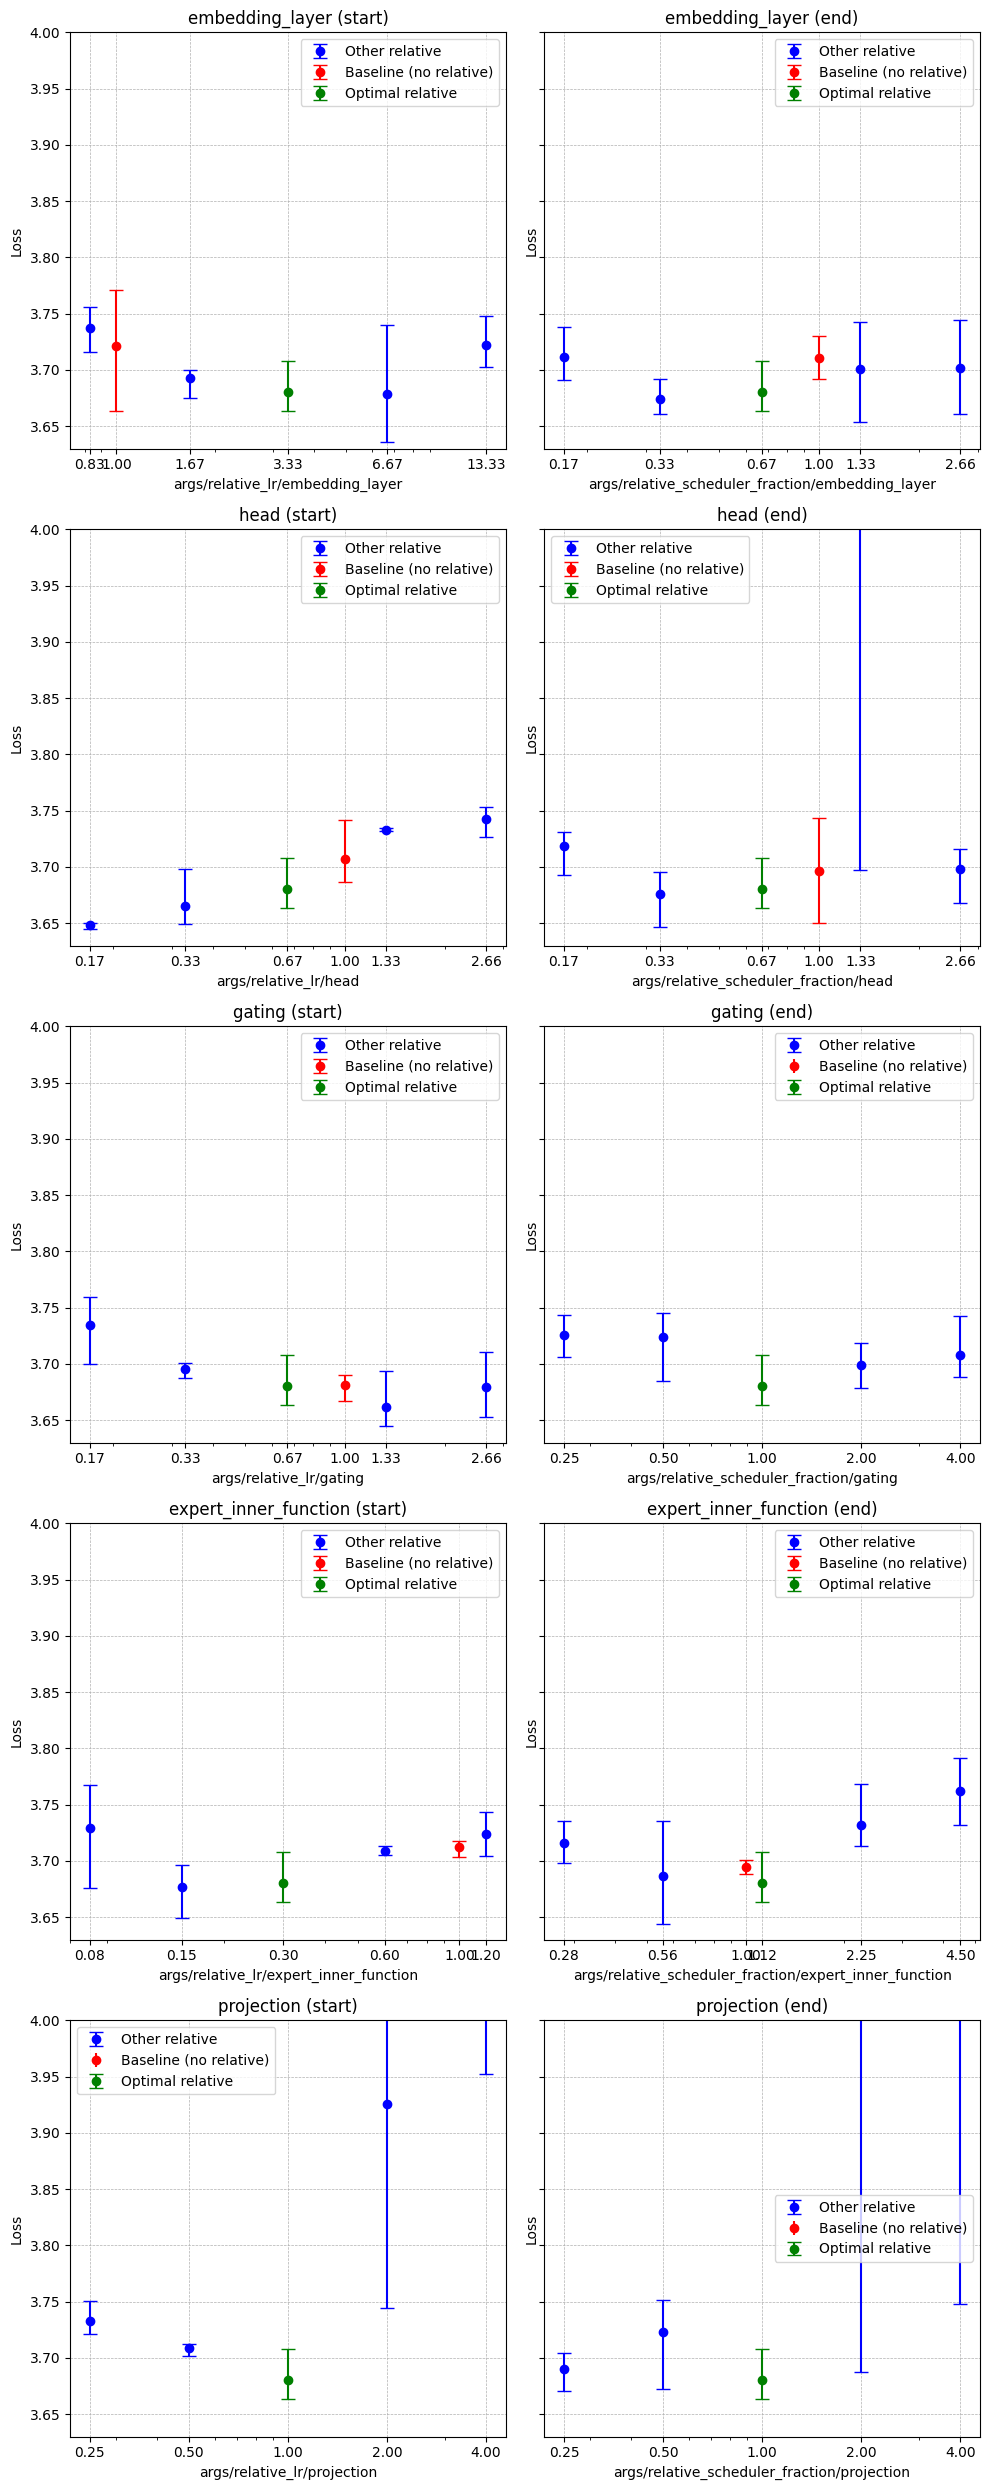

In [41]:
import matplotlib.pyplot as plt
import numpy as np

component_names = ['embedding_layer', 'head', 'gating', 'expert_inner_function', 'projection']
start_ends = ['start', 'end']

# Create subplots with 2 rows and 5 columns
fig, axs = plt.subplots(len(component_names), len(start_ends), sharey=True, figsize=(10, 25))

# Loop through components and start_ends
for i, name in enumerate(component_names):
    for j, start_end in enumerate(start_ends):
        ax = axs[i, j]
        plot_std_component(table=std_medium_df, component_name=name, start_end=start_end, ax=ax)
        ax.set_title(f'{name} ({start_end})')

for ax in axs.flat:
    ax.set_ylim(3.63, 4)

# Adjust layout to make room for labels
plt.tight_layout()
plt.savefig('U-plots-std.png')
plt.show()


component_name: embedding_layer, start_end: start
x_values: [ 0.83  1.67  6.67 13.33  1.    3.33]


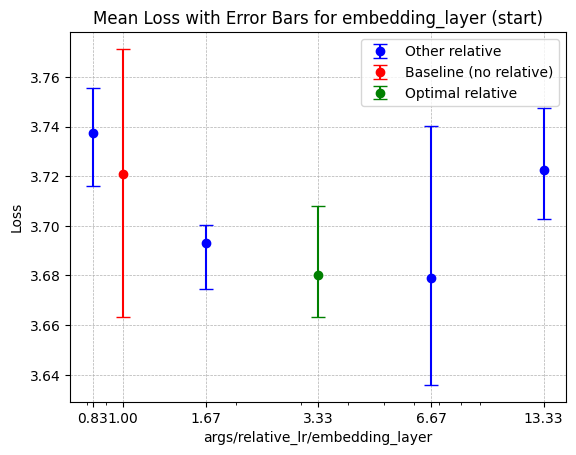

In [37]:
plot_std_component(table=std_medium_df, component_name="embedding_layer", start_end="start")


# Component ablations